In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import time

import cv2
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.distributed import DistributedSampler
from PIL import Image
from typing import Any, Callable, List, Optional, Union, Tuple
from glob import glob
import horovod.torch as hvd

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

hvd.init()

if torch.cuda.is_available():
    torch.cuda.set_device(hvd.local_rank())

In [3]:
class CatsvsDogs(Dataset):
    def __init__(self, root: str, transform, phase: str = 'train'):
        # 데이터셋의 전처리를 해주는 부분
        '''
         Cats-vs-Dogs dataset download from https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset

         root: str = "../Cats-vs-Dogs"
         phase: str = 'train' or 'test'
         transform: torchvision.transforms.Compose()
        '''

        def get_img_path(root: str):
            # "/data/DataSet/Cats-vs-Dogs/"
            if root[-1] == "/":
                root = root
            else:
                root = root + "/"

            dog_img_path = glob(root + "PetImages/Dog/*.jpg")
            cat_img_path = glob(root + "PetImages/Cat/*.jpg")

            assert phase == "test" or phase == "train", f"{phase} is not match. phase using train or test"

            if phase == "train":
                return dog_img_path[:int(len(dog_img_path) * 0.8)] + cat_img_path[:int(len(cat_img_path) * 0.8)]
            else:
                return dog_img_path[int(len(dog_img_path) * 0.8) :] + cat_img_path[:int(len(cat_img_path) * 0.8) :]

        self.transform = transform

        self.img_path = get_img_path(root)
        

    def __len__(self):
        # 데이터셋 길이, 총 샘플의 수를 리턴
        return len(self.img_path)

    def __getitem__(self, idx):
        # 데이터셋에서 특정 1개의 샘플을 가져오는 함수
        img_path = self.img_path[idx]
        
        img = Image.open(img_path).convert("RGB")

        img_transformed = self.transform(img)

        label = img_path.split('/')[-2]

        if label == "Dog":
            label = 1
        elif label == "Cat":
            label = 0
            
        return img_transformed, label

In [4]:
train_data = CatsvsDogs(
    root = "/data/DataSet/Cats-vs-Dogs/",
    phase="train",
    transform=transforms.Compose([
        transforms.RandomResizedCrop(
            size=(224, 224),
            scale=(0.5, 1.0)
        ),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=(0.5, 0.5, 0.5),
            std=(0.5, 0.5, 0.5)
        )
    ])
)

train_sampler = DistributedSampler(
    dataset=train_data,
    num_replicas=hvd.size(),
    rank=hvd.rank()
)

batch_size = 256
num_workers = 4

train_loader = DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    num_workers=num_workers,
    sampler=train_sampler
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

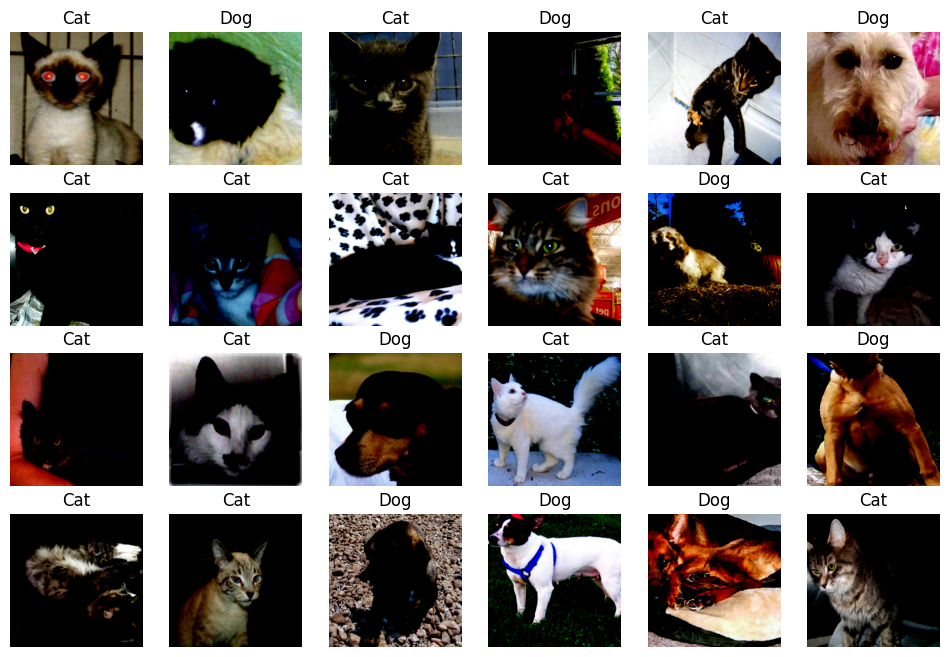

In [6]:
rows, cols = 4, 6

fig = plt.figure(figsize=(12, 8))

for idx in range(1, rows * cols + 1):
    random_img_number = np.random.randint(len(train_data))
    random_img = train_data[random_img_number][0].numpy()
    fig.add_subplot(rows, cols, idx)
    if train_data[random_img_number][1] == 0:
        label = "Cat"
    else:
        label = "Dog"
    plt.title(label)  # type: ignore
    plt.axis('off')
    plt.imshow(np.transpose(random_img, (1, 2, 0)))

plt.show()

In [7]:
class BasicBlock(nn.Module):
    '''
    Basic Resblock

    3x3 -> 3x3
    '''
    expansion = 1

    def __init__(self, in_channels, out_channels, downsample=False):
        super().__init__()

        layers = [
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(
                num_features=out_channels
            ),
            nn.Conv2d(
                in_channels=out_channels,
                out_channels=out_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(
                num_features=out_channels
            ),
            nn.ReLU(
                inplace=True
            )
        ]

        if downsample:
            layers.append(
                nn.Conv2d(
                    in_channels=out_channels,
                    out_channels=out_channels,
                    kernel_size=1,
                    stride=1,
                    bias=False
                ),
                nn.BatchNorm2d(
                    num_features=out_channels
                ),
                nn.ReLU(
                    inplace=True
                )
            )
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return x + self.model(x)

In [8]:
class Bottleneck(nn.Module):
    '''
    Bottleneck Resblock

    1x1 -> 3x3 -> 1x1
    '''

    expansion = 4

    def __init__(self, in_channels, out_channels, downsample=False):
        super(Bottleneck, self).__init__()

        layers = [
            # I+2P-K/S +1 = O

            # 1x1
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=1,
                stride=1,
                padding=0
            ),
            nn.BatchNorm2d(
                num_features=out_channels
            ),
            nn.ReLU(
                inplace=True
            ),

            # 3x3
            nn.Conv2d(
                in_channels=out_channels,
                out_channels=out_channels,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(
                num_features=out_channels
            ),
            nn.ReLU(
                inplace=True
            ),

            # 1x1
            nn.Conv2d(
                in_channels=out_channels,
                out_channels=out_channels,
                kernel_size=1,
                stride=1,
                padding=0
            ),
            nn.BatchNorm2d(
                num_features=out_channels
            ),
            nn.ReLU(
                inplace=True
            )
        ]

        if downsample:
            layers.append(
                nn.Conv2d(
                    in_channels=out_channels,
                    out_channels=out_channels,
                    kernel_size=1,
                    stride=1,
                    bias=False
                ),
                nn.BatchNorm2d(
                    num_features=out_channels
                ),
                nn.ReLU(
                    inplace=True
                )
            )

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return x + self.model(x)

In [ ]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim, zero_init_residual = False):
        super(ResNet, self).__init__()

        block, n_blocks, channels = config

        self.in_channels = channels[0]

        assert len(n_blocks) == len(channels) == 4

        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=self.in_channels,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride=2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride=2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(
            in_features=self.in_channels, 
            out_features=output_dim
            )

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    

    def get_resnet_layer


In [ ]:
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

resnet18_config = ResNetConfig(
    block=BasicBlock,
    n_blocks=[2, 2, 2, 2],
    channels=[64, 128, 256, 512]
    )

resnet34_config = ResNetConfig(
    block=BasicBlock,
    n_blocks=[3, 4, 6, 3],
    channels=[64, 128, 256, 512]
)

resnet50_config = ResNetConfig(
    block=Bottleneck,
    # 16 x 3 = 48
    n_blocks=[3, 4, 6, 3],
    channels=[256, 512, 1024, 2048]
)

resnet101_config = ResNetConfig(
    block=Bottleneck,
    n_block=[3, 4, 23, 3],
    channels=[256, 512, 1024, 2048]
)

resnet152_config = ResNetConfig(
    block=Bottleneck,
    # 50 x 3 = 150
    n_block=[3, 8, 36, 3],
    channels=[256, 512, 1024, 2048]
)

models.

In [ ]:
num_epochs = 200

writer = SummaryWriter("Tensorboard/")

for epoch in range(1, num_epochs + 1):
    for idx, (imgs, labels) in tqdm(enumerate(train_loader)):